# Bitcoin
Dựa trên các tập train/val/test đã chia sẵn và chỉ sử dụng cột `Price` làm input cho mô hình LSTM.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Optional for inline plots
%matplotlib inline

## 1. Đọc dữ liệu đã chia sẵn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_path = '/content/drive/MyDrive/Colab Notebooks/8_1_1/btc_train.csv'
val_path   = '/content/drive/MyDrive/Colab Notebooks/8_1_1/btc_val.csv'
test_path  = '/content/drive/MyDrive/Colab Notebooks/8_1_1/btc_test.csv'

train_df = pd.read_csv(train_path, parse_dates=['Date'], index_col='Date')
val_df   = pd.read_csv(val_path,   parse_dates=['Date'], index_col='Date')
test_df  = pd.read_csv(test_path,  parse_dates=['Date'], index_col='Date')

train_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-01,7199.8,7196.4,7259.4,7180.0,420280.0,0.05
2020-01-02,6967.0,7199.7,7209.6,6901.4,632780.0,-3.23
2020-01-03,7343.1,6967.1,7402.9,6884.1,936290.0,5.40
2020-01-04,7376.8,7345.1,7433.1,7291.4,523910.0,0.46
2020-01-05,7372.5,7376.8,7501.0,7345.6,628140.0,-0.06


## 2. Tiền xử lý và scale cột `Price`

In [ ]:
scaler = MinMaxScaler()
train_prices = train_df[['Price']].values
scaled_train = scaler.fit_transform(train_prices)

val_prices  = val_df[['Price']].values
scaled_val   = scaler.transform(val_prices)

test_prices = test_df[['Price']].values
scaled_test  = scaler.transform(test_prices)

## 3. Tạo sequence cho LSTM

In [ ]:
def create_sequences(data, time_steps=100):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i: i + time_steps])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 100
X_train, y_train = create_sequences(scaled_train, time_steps)
X_val,   y_val   = create_sequences(scaled_val,   time_steps)
X_test,  y_test  = create_sequences(scaled_test,  time_steps)

# reshape for LSTM: (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], time_steps, 1))
X_val   = X_val.reshape((X_val.shape[0], time_steps, 1))
X_test  = X_test.reshape((X_test.shape[0], time_steps, 1))

## 4. Xây dựng và huấn luyện mô hình LSTM

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Giả sử time_steps = 100 và n_features = 1
model = Sequential()
# Tầng LSTM đầu tiên, trả về toàn bộ sequence để làm đầu vào cho tầng kế tiếp
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, 1)))
# Tầng LSTM thứ hai, cũng trả về toàn bộ sequence
model.add(LSTM(50, return_sequences=True))
# Tầng LSTM thứ ba, chỉ trả về output cuối cùng
model.add(LSTM(50))
# Tầng đầu ra
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
# Callback chống overfit
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - loss: 0.0633 - val_loss: 0.0040
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.0033 - val_loss: 0.0058
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━

### 4.1. Đồ thị quá trình huấn luyện

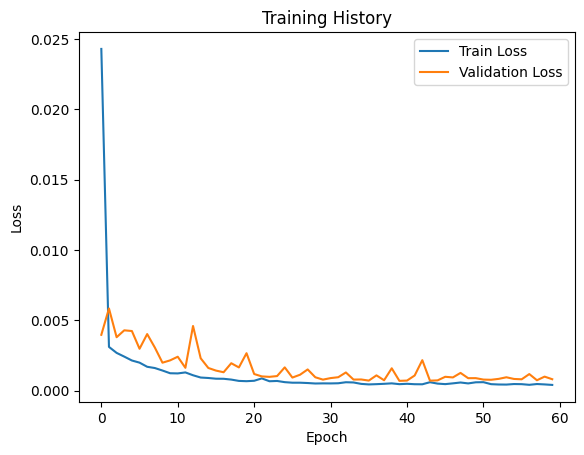

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5. Dự đoán và chuyển ngược scale

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_val  = model.predict(X_val)

y_pred_test_inv = scaler.inverse_transform(y_pred_test).flatten()
y_test_inv      = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

y_pred_val_inv = scaler.inverse_transform(y_pred_val).flatten()
y_val_inv      = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


### 5.1. Đồ thị Actual vs Predicted trên tập Test

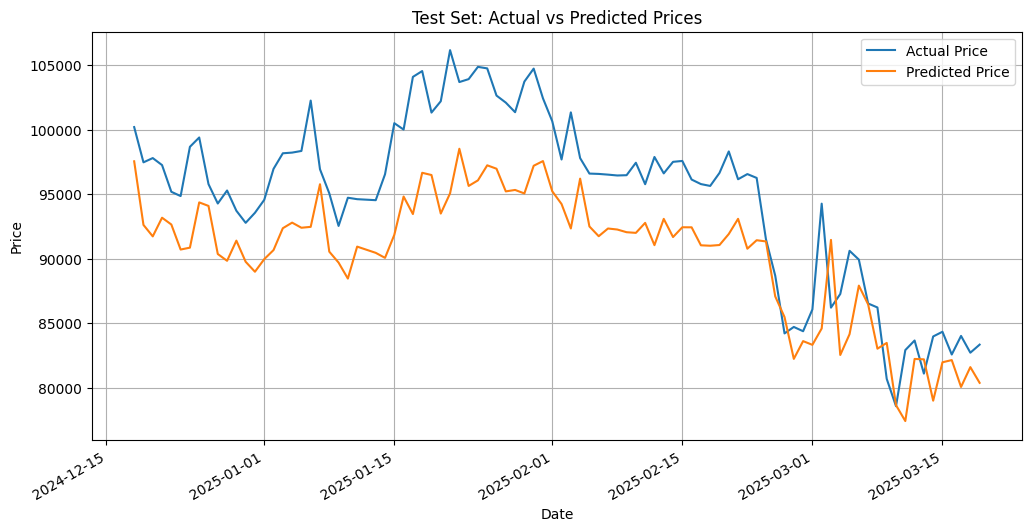

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Giả sử bạn đã có test_df, model và các mảng y_test_inv, y_pred_test_inv
# time_steps là số bước history (ví dụ 100)
# Lấy dates khớp với y_test_inv
dates = test_df.index[time_steps:].copy()

# Chắc chắn độ dài khớp nhau
assert len(dates) == len(y_test_inv), f"{len(dates)} vs {len(y_test_inv)}"

# Vẽ
plt.figure(figsize=(12,6))
plt.plot(dates, y_test_inv, label='Actual Price')
plt.plot(dates, y_pred_test_inv, label='Predicted Price')

# Định dạng trục x là ngày tháng
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Xoay nhãn ngày cho dễ đọc

plt.title('Test Set: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


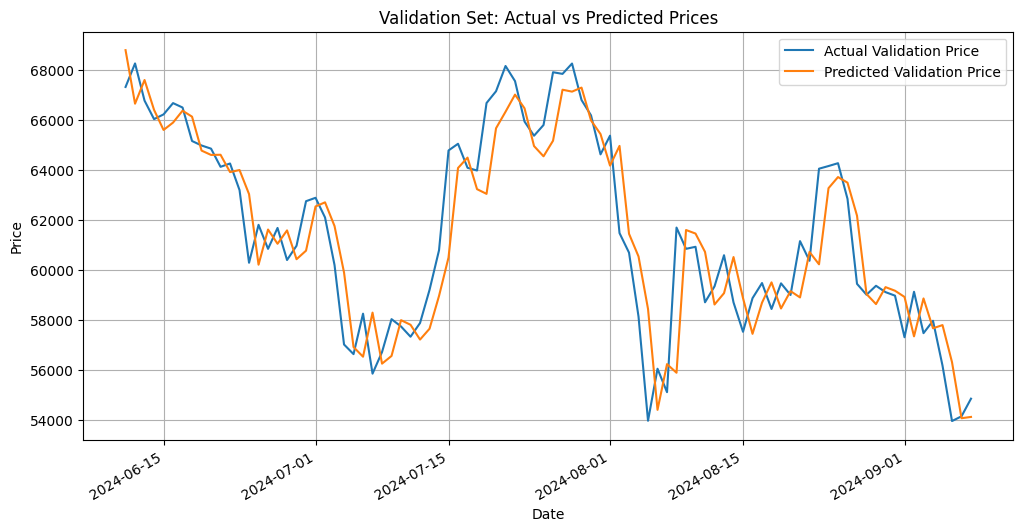

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Giả sử bạn đã có val_df, y_val_inv, y_pred_val_inv và time_steps
dates_val = val_df.index[time_steps:].copy()

# Kiểm tra độ dài
assert len(dates_val) == len(y_val_inv), f"{len(dates_val)} vs {len(y_val_inv)}"

# Vẽ
plt.figure(figsize=(12,6))
plt.plot(dates_val, y_val_inv,      label='Actual Validation Price')
plt.plot(dates_val, y_pred_val_inv, label='Predicted Validation Price')

# Định dạng trục x ngày tháng
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.title('Validation Set: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Với tập test
mse_test  = mean_squared_error(y_test_inv,  y_pred_test_inv)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv) * 100  # % error

print(f"Test MSE:  {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAPE: {mape_test:.2f}%")

# Với tập validation
mse_val  = mean_squared_error(y_val_inv,  y_pred_val_inv)
rmse_val = np.sqrt(mse_val)
mape_val = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv) * 100

print(f"Val   MSE:  {mse_val:.4f}")
print(f"Val   RMSE: {rmse_val:.4f}")
print(f"Val   MAPE: {mape_val:.2f}%")


Test MSE:  28133500.9679
Test RMSE: 5304.1023
Test MAPE: 4.85%
Val   MSE:  2737819.9045
Val   RMSE: 1654.6359
Val   MAPE: 2.06%


In [ ]:
import numpy as np
import pandas as pd

def predict_future_univariate(model, last_seq, n_days, scaler):
    """
    model    : LSTM đã train với input_shape=(time_steps,1)
    last_seq : mảng NumPy shape (time_steps,1) chứa giá scaled của time_steps cuối cùng
    n_days   : số ngày cần dự đoán tiếp
    scaler   : MinMaxScaler đã fit trên cột Price
    """
    preds = []
    seq = last_seq.copy()  # (time_steps, 1)

    for _ in range(n_days):
        x_input = seq.reshape(1, *seq.shape)    # (1, time_steps, 1)
        yhat = model.predict(x_input, verbose=0)[0,0]
        preds.append(yhat)

        # update sequence: drop phần tử đầu, thêm yhat vào cuối
        seq = np.vstack([seq[1:], [[yhat]]])

    # inverse transform về giá gốc
    inv = scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()
    return inv

# --- Ví dụ sử dụng ---
time_steps = 100
# Lấy last_seq từ scaled_test (shape (len_test,1))
last_seq = scaled_test[-time_steps:]

# Dự đoán 30, 60, 90 ngày
pred_30 = predict_future_univariate(model, last_seq, 30, scaler)
pred_60 = predict_future_univariate(model, last_seq, 60, scaler)
pred_90 = predict_future_univariate(model, last_seq, 90, scaler)

# Tạo mảng ngày tương ứng
last_date = test_df.index[-1]
dates_30 = pd.date_range(last_date + pd.Timedelta(days=1), periods=30)
dates_60 = pd.date_range(last_date + pd.Timedelta(days=1), periods=60)
dates_90 = pd.date_range(last_date + pd.Timedelta(days=1), periods=90)

# Bây giờ bạn có thể dùng dates_* và pred_* để vẽ hoặc phân tích tiếp


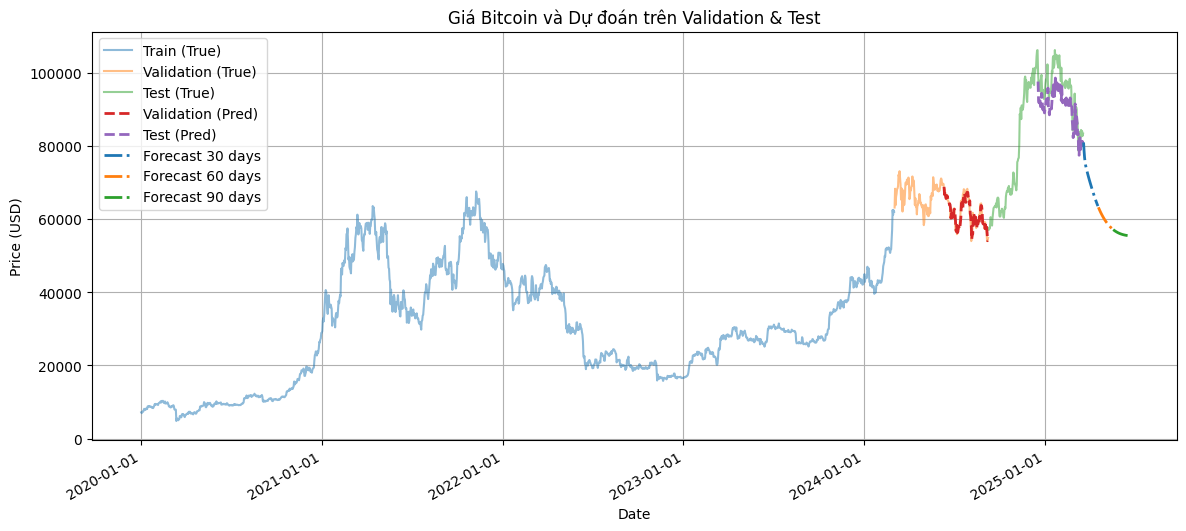

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Giả sử bạn đã có:
# - train_df, val_df, test_df
# - y_val_inv, y_pred_val_inv
# - y_test_inv, y_pred_test_inv
# - time_steps (ví dụ =100)

# Tạo dates cho validation và test (bỏ đi time_steps đầu)
dates_val = val_df.index[time_steps:]
dates_test = test_df.index[time_steps:]

plt.figure(figsize=(14,6))

# Vẽ giá gốc
plt.plot(train_df.index, train_df['Price'],            label='Train (True)',      alpha=0.5)
plt.plot(val_df.index,   val_df['Price'],              label='Validation (True)', alpha=0.5)
plt.plot(test_df.index,  test_df['Price'],             label='Test (True)',       alpha=0.5)

# Vẽ dự đoán
plt.plot(dates_val, y_pred_val_inv,   '--', label='Validation (Pred)', linewidth=2)
plt.plot(dates_test, y_pred_test_inv, '--', label='Test (Pred)',       linewidth=2)
# Vẽ dự đoán tương lai 30, 60, 90 ngày
# 30 ngày đầu tiên
plt.plot(dates_30, pred_30, '-.', color='tab:blue', label='Forecast 30 days', linewidth=2)
# 31–60 ngày, vẽ tiếp
plt.plot(dates_60[30:], pred_60[30:], '-.', color='tab:orange', label='Forecast 60 days', linewidth=2)
# 61–90 ngày, vẽ tiếp
plt.plot(dates_90[60:], pred_90[60:], '-.', color='tab:green', label='Forecast 90 days', linewidth=2)


# Định dạng trục ngày
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.title('Giá Bitcoin và Dự đoán trên Validation & Test')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

